# Adaptive Gaussian

We use the centroid of the area with most energy in the blob (as measured by an Euclidean distance transform). Then, we compute the shortest distance from the centroid to a background pixel in 8 directions, and use this value as the sigma for the Gaussian filter.

In [84]:
import scipy.ndimage
import skimage.io
import skimage.filters
import matplotlib.pyplot as plt
import numpy as np

def segment_distance(start, X, dir):
  current = start.copy()
  while True:
    new = current + dir
    if X[new[0], new[1]] > 0.0:
      current = new
    else:
      break
  return np.linalg.norm(new - start)

def adaptive_gaussian(b, z_score = None, thresh_add = True, truncate=4.0,
                      additive_c=0.0):
  # Blob with Euclidean distance transform
  t = scipy.ndimage.distance_transform_edt(b)

  # Normal centroid
  nc = np.argwhere(b)
  nc = np.ceil(np.sum(nc, axis=0) / len(nc)).astype("int32")
  print("nc: ", nc)

  # "Energy centroid"
  ec = np.argwhere(t >= np.max(t))
  ec = np.ceil(np.sum(ec, axis=0) / len(ec)).astype("int32")
  print("ec: ", ec)

  # Segment distances from the energy centroid
  # in 8 directions
  sds = []
  sds.append(segment_distance(ec, b, [0, -1]))
  sds.append(segment_distance(ec, b, [0, 1]))
  sds.append(segment_distance(ec, b, [-1, 0]))
  sds.append(segment_distance(ec, b, [1, 0]))
  sds.append(segment_distance(ec, b, [1, 1]))
  sds.append(segment_distance(ec, b, [1, -1]))
  sds.append(segment_distance(ec, b, [-1, -1]))
  sds.append(segment_distance(ec, b, [-1, 1]))
  sd_min = np.min(sds)
  sigma = sd_min * 0.5

  # T blob
  tb = t.copy()
  if z_score is not None:
    mean = np.mean(tb)
    std = np.std(tb)
    thresh = mean + (z_score * std)
    if thresh_add:
      tb[tb >= thresh] += np.sum(tb[tb < thresh]) / (len(tb[tb >= thresh]) or 1.0)
    tb[tb < thresh] = 0.0

  tb = t / (np.sum(tb) or 1.0)
  print("Tb sum: ", np.sum(tb))
  tb += additive_c
  print("Tb sum (after additive_c): ", np.sum(tb))

  # Gaussian blob
  gb = np.zeros_like(b)
  gb[ec[0], ec[1]] = 1.0
  gb = skimage.filters.gaussian(gb, sigma, mode="nearest", truncate=truncate)
  gb[b == 0.0] = 0.0

  # Threshold the gaussian blob
  if z_score is not None:
    mean = np.mean(gb)
    std = np.std(gb)
    thresh = mean + (z_score * std)
    if thresh_add:
      gb[gb >= thresh] += np.sum(gb[gb < thresh]) / (len(gb[gb >= thresh]) or 1.0)
    gb[gb < thresh] = 0.0

  gb /= (np.sum(gb) or 1.0)
  print("Gb sum: ", np.sum(gb))
  gb += additive_c
  print("Gb sum (after additive_c): ", np.sum(gb))

  # Alternative usage of the Gaussian filter
  gb2 = skimage.filters.gaussian(b, sigma, mode="nearest", truncate=truncate)
  gb2[b == 0] = 0

  if z_score is not None:
    mean = np.mean(gb2)
    std = np.std(gb2)
    thresh = mean + (z_score * std)
    if thresh_add:
      gb2[gb2 >= thresh] += np.sum(gb2[gb2 < thresh]) / (len(gb2[gb2 >= thresh]) or 1.0)
    gb2[gb2 < thresh] = 0.0

  gb2 /= (np.sum(gb2) or 1.0)
  print("Gb2 sum: ", np.sum(gb2))
  gb2 += additive_c
  print("Gb sum (after additive_c): ", np.sum(gb2))

  fig = plt.figure(figsize=(24, 6))

  ax1 = fig.add_subplot(1, 4, 1)
  ax1.set_title("Centroids")
  skimage.io.imshow(b, cmap="gray", ax=ax1)
  ax1.plot(nc[1], nc[0], color="red", marker="+", markersize=10, label="standard")
  ax1.plot(ec[1], ec[0], color="red", marker="x", markersize=10, label="energy")
  ax1.legend()

  ax2 = fig.add_subplot(1, 4, 2)
  ax2.set_title(f"EDT on blob mask\nz_score={z_score}, additive_c={additive_c:.2f}")
  skimage.io.imshow(tb, cmap="jet", ax=ax2)

  ax3 = fig.add_subplot(1, 4, 3)
  ax3.set_title(f"Adaptive Gaussian kernel on energy centroid \nsigma={sigma:.2f}, z_score={z_score:}, additive_c={additive_c:.2f}")
  ax3.imshow(b, cmap="gray")
  skimage.io.imshow(gb, cmap="jet", ax=ax3, alpha=0.8)

  ax4 = fig.add_subplot(1, 4, 4)
  ax4.set_title(f"Adaptive Gaussian kernel on blob mask \nsigma={sigma:.2f}, z_score={z_score}, additive_c={additive_c:.2f}")
  skimage.io.imshow(gb2, cmap="jet", ax=ax4)

An case in which the normal centroid definition is the same as the energy centroid.

nc:  [60 60]
ec:  [60 60]
Tb sum:  1.0
Tb sum (after additive_c):  7200.999999999999
Gb sum:  1.0
Gb sum (after additive_c):  7201.0
Gb2 sum:  1.0
Gb sum (after additive_c):  7200.999999999999


/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


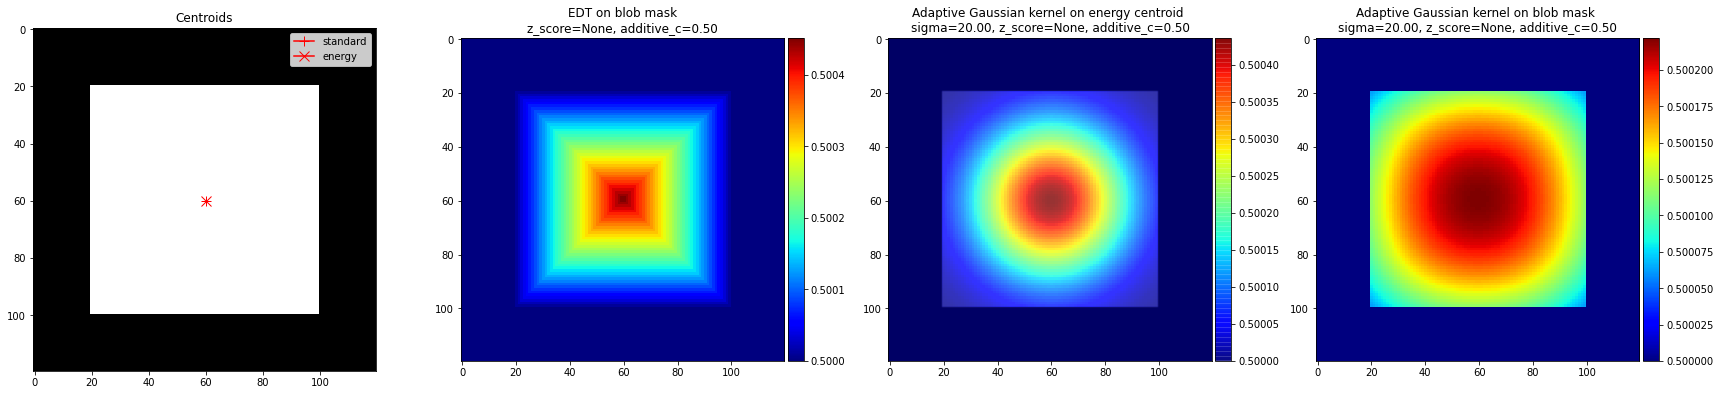

In [85]:
# Blob mask
b = np.zeros((120, 120))
b[20:100, 20:100] = 1.0

adaptive_gaussian(b, z_score=None, additive_c=0.5)

Applying thresholding:

nc:  [60 60]
ec:  [60 60]
Tb sum:  0.9999999999999998
Tb sum (after additive_c):  7200.999999999999
Gb sum:  0.9999999999999999
Gb sum (after additive_c):  7201.0
Gb2 sum:  1.0
Gb sum (after additive_c):  7201.0


/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


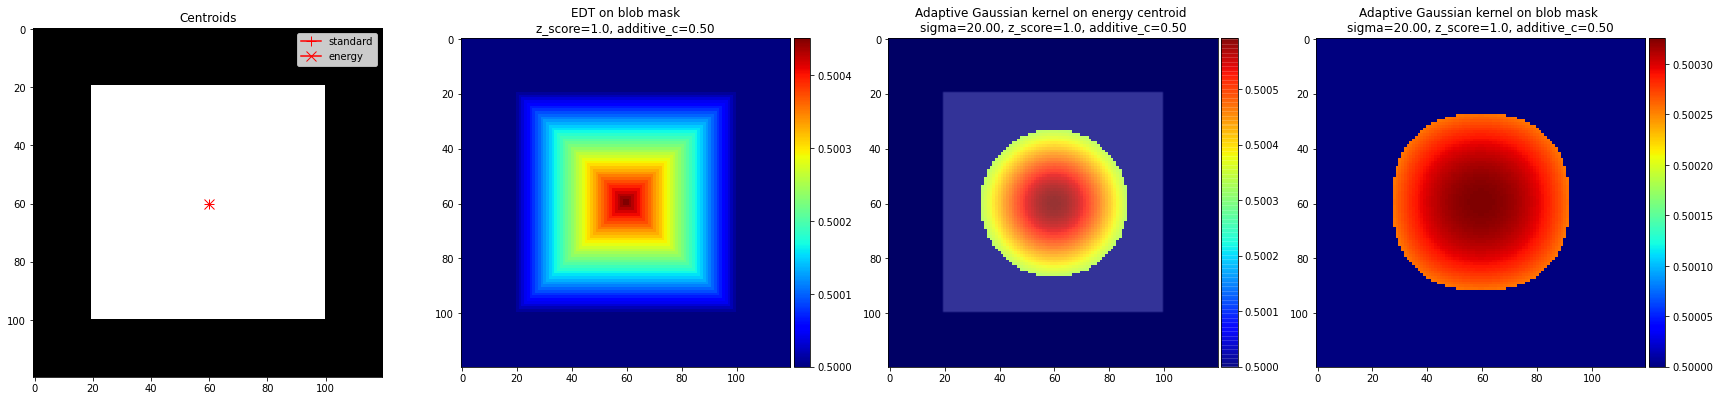

In [86]:
adaptive_gaussian(b, z_score=1.0, additive_c=0.5)

A case where we can see how the region with most energy can helps us define a better centroid.

nc:  [58 62]
ec:  [60 80]
Tb sum:  1.0
Tb sum (after additive_c):  7201.0
Gb sum:  1.0000000000000002
Gb sum (after additive_c):  7201.0
Gb2 sum:  1.0
Gb sum (after additive_c):  7201.0


/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


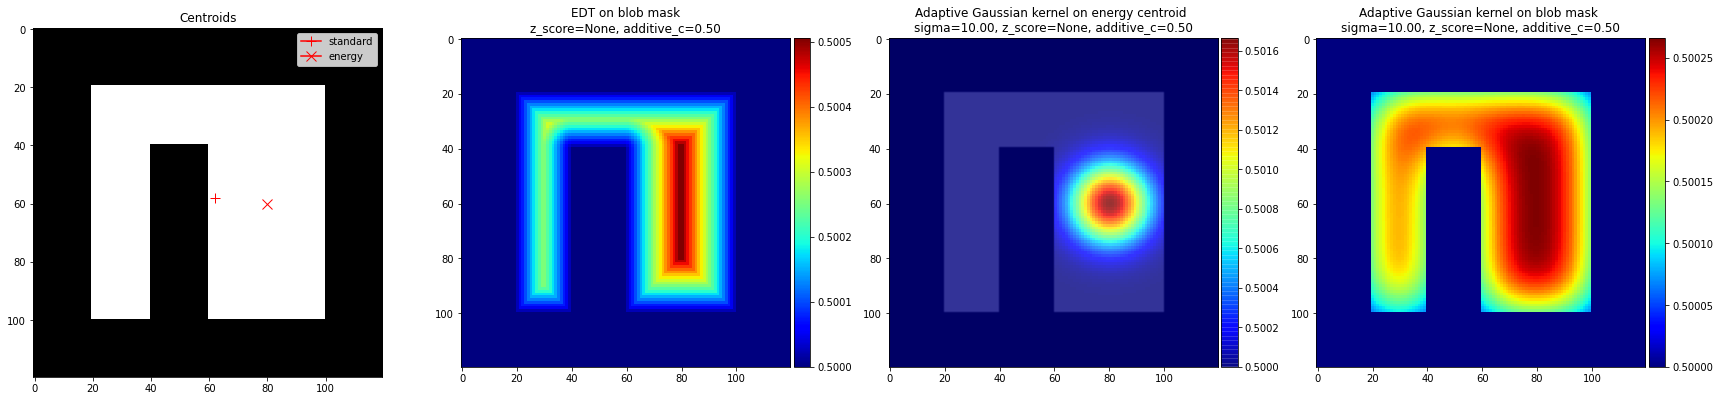

In [87]:
  # Blob mask
  b = np.zeros((120, 120))
  b[20:40, 20:100] = 1.0
  b[40:100, 20:40] = 1.0
  b[40:100, 60:100] = 1.0

  adaptive_gaussian(b, z_score=None, additive_c=0.5)

nc:  [58 62]
ec:  [60 80]
Tb sum:  1.0
Tb sum (after additive_c):  7201.0
Gb sum:  0.9999999999999998
Gb sum (after additive_c):  7201.0
Gb2 sum:  1.0
Gb sum (after additive_c):  7201.0


/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


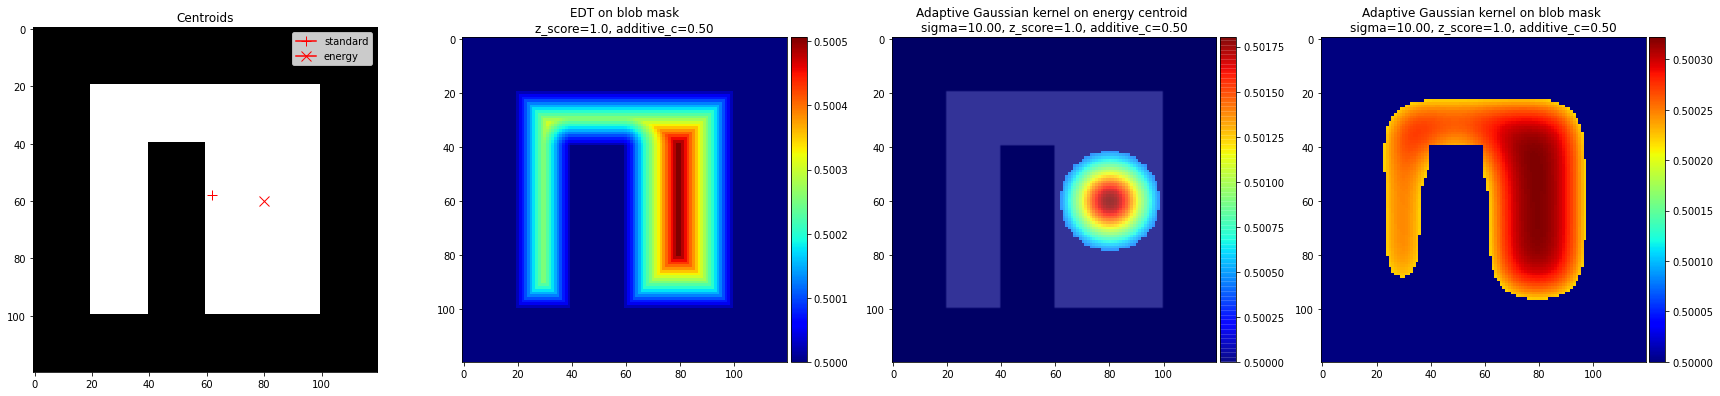

In [88]:
  adaptive_gaussian(b, z_score=1.0, additive_c=0.5)

nc:  [54 60]
ec:  [32 60]
Tb sum:  1.0
Tb sum (after additive_c):  7201.0
Gb sum:  0.9999999999999998
Gb sum (after additive_c):  7201.0
Gb2 sum:  1.0000000000000002
Gb sum (after additive_c):  7201.0


/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


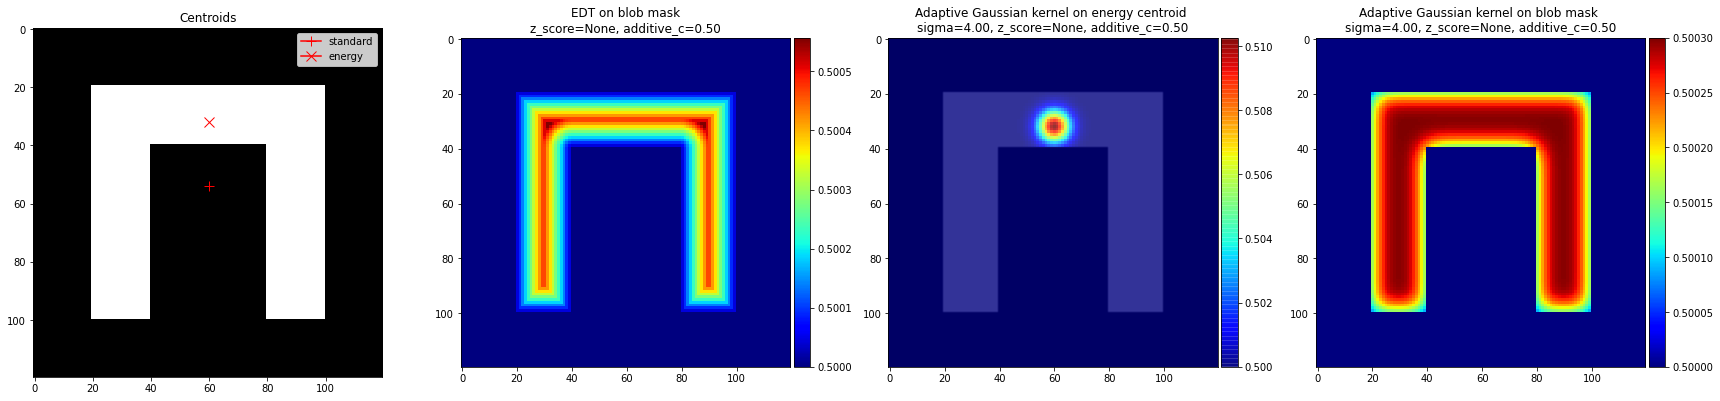

In [89]:
  # Blob mask
  b = np.zeros((120, 120))
  b[20:40, 20:100] = 1.0
  b[40:100, 20:40] = 1.0
  b[40:100, 80:100] = 1.0

  adaptive_gaussian(b, z_score=None, additive_c=0.5)

nc:  [54 60]
ec:  [32 60]
Tb sum:  1.0
Tb sum (after additive_c):  7201.0
Gb sum:  1.0
Gb sum (after additive_c):  7201.0
Gb2 sum:  1.0
Gb sum (after additive_c):  7201.0


/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


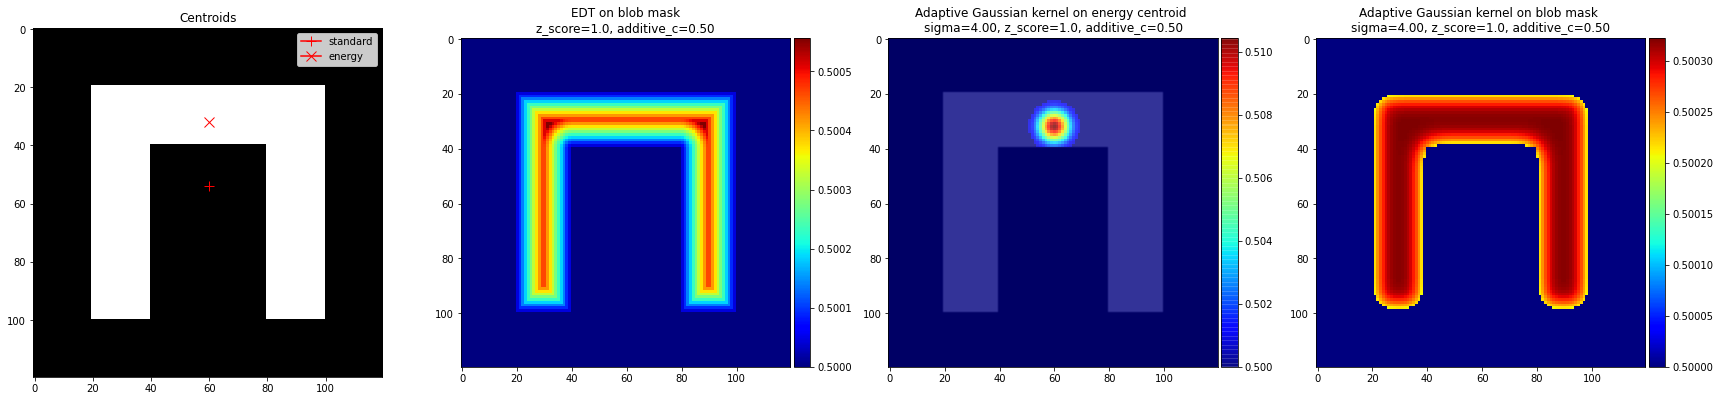

In [90]:
adaptive_gaussian(b, z_score=1.0, additive_c=0.5)